# Stack Overflow: Tag Prediction

### Summary :

* Stack Overflow is a question and answer site for professional and enthusiast programmers. It features questions and answers on a wide range of topics in computer programming.The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Reddit.

* As of March 2021 Stack Overflow has over 14 million registered users,and has received over 21 million questions and 31 million answers. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: JavaScript, Java, C#, PHP, Android, Python, jQuery, and HTML.

<p style='font-size:18px'><b> Use case : </b></p>

* predict the correct tags based on the 'title' and 'description' of the question posted on Stackoverflow.

### Objectives and Constraints :

* Predict as many tags as possible with high precision and recall.
* No strict latency.
* predicting incorrect tags impact customer experience. 

### Data Overview :

* train.csv contains 4 columns. they are, Id,Title, Body, Tags.
* test.csv contains same columns except Tags column.
* The columns in the table are:

    Id - Unique identifier for each question

    Title - The question's title

    Body - The body of the question

    Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')

### Type of Machine Learning problem :

* It is multilable classification problem
* Multi-label Classification: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these.

### Performance Metrics :

* We’re challenged to build a multi-labeld model that’s capable of predict different types of tags for each question on Stack Overflow.
* We need to create a model which predicts a probability of each type of tag.
* The evaluation measures for single-label are usually different than for multi-label. Here in single-label classfication we use simple metrics such as precision, recall, accuracy, etc
* In multi-label classification, a misclassification is no longer a hard wrong or right. A prediction containing a subset of the actual classes should be considered better than a prediction that contains none of them, i.e., predicting two of the three labels correctly this is better than predicting no labels at all.

* To measure a multi-class classifier we have to average out the classes somehow. There are two different methods of doing this called <B> micro-averaging and macro-averaging</B>.
* In <B> micro-averaging</B> all TPs, TNs, FPs and FNs for each class are summed up and then the average is taken.

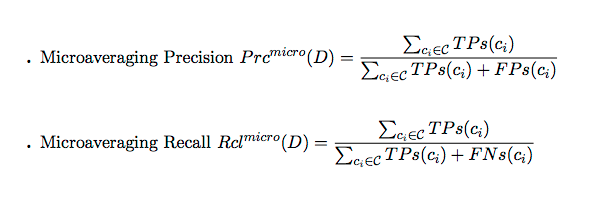

* In  micro-averaging method, you sum up the individual true positives, false positives, and false negatives of the system for different sets and the apply them. And the micro-average F1-Score will be simply the harmonic mean of above two equations.

* <B>Macro-averaging</B> is straight forward. We just take the average of the precision and recall of the system on different sets.

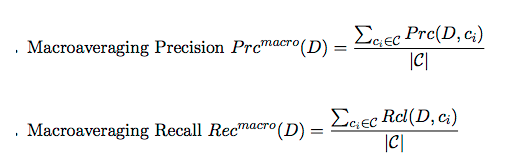

* Macro-averaging method can be used when you want to know how the system performs overall across the sets of data. You should not come up with any specific decision with this average. On the other hand, micro-averaging can be a useful measure when your dataset varies in size.

<B>Hamming-Loss</B> : 
* In simplest of terms, Hamming-Loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.

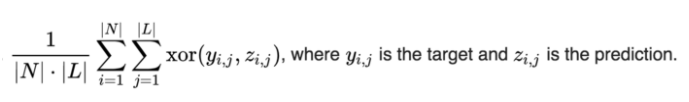

<b>Exact Match Ratio (Subset accuracy):</b>  
* It is the most strict metric, indicating the percentage of samples that have all their labels classified correctly.

* In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

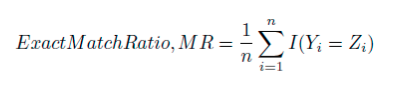

* There is a function in scikit-learn which implements subset accuracy, called as accuracy_score.

### Importing Libraries

In [253]:
# Genral lib
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import os
import datetime as dt
import csv
import copy
# viz lib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# DB lib
import sqlite3
from sqlalchemy import create_engine
# vectorizers lib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
## ML models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
## performance metrics 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.metrics import classification_report

### Loading and Intial Analysis of Data :

In [2]:
# changing directory to DB folder
os.chdir(r'D:\Machine Learning Projects\Stack Overflow Tag Predictor\Data')
print(os.getcwd())

D:\Machine Learning Projects\Stack Overflow Tag Predictor\Data


In [115]:
if os.path.isfile('processed.db'):
    con = sqlite3.connect('processed.db')
    #tables = pd.read_sql_query("""SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';""",con)
    #num_rows = pd.read_sql_query("""SELECT COUNT(*) FROM QuestionsProcessed""",con)
    proc_df = pd.read_sql_query(""" SELECT * from QuestionsProcessed LIMIT 10""",con)

In [111]:
tables

,name
0,QuestionsProcessed


In [113]:
num_rows

,COUNT(*)
0,999999


In [116]:
proc_df

,question,code,tags,words_pre,words_post,is_code
0,chang cpu soni vaio pcg grx tri everywher find...,[],cpu motherboard sony-vaio replacement disassembly,535,284,0
1,display size grayscal qimag qt abl display ima...,"['transformPixels(0,0,1,imheight,imwidth,1);//...",c++ qt qt4,535,563,1
2,datagrid selecteditem set back null eventtocom...,"['&lt;sdk:DataGrid Name=""MyGrid"" AutoGenerate...",mvvm silverlight-4.0,535,420,1
3,filter string collect base listview item resol...,"['string[]', 'nicks.Count !=0', 'string[]', 'f...",c# winforms string listview collections,535,597,1
4,disabl home button without use type keyguard c...,[' @Override\n public void onCreate(Bund...,android android-layout android-manifest androi...,535,487,1
5,php gd multipl imag white background warn use ...,[' //create new images\n $nimgac_0=image...,php image-processing warnings gd,535,970,1
6,object c sqlite select work make select tabl s...,"["" // copy the database to the user's direc...",objective-c,535,145,1
7,extend function random class tri extend functi...,['public static class RandomExtensions\n{\n ...,c# random static extension-methods seed,535,276,1
8,android tablet develop easili done ic futur em...,[],android honeycomb ice-cream-sandwich backwards...,535,298,0
9,one explain java c implement graph data struct...,[],c# java algorithm data-structures graph-algorithm,535,205,0


In [3]:
if os.path.isfile('train_no_dup.db'):
    con = sqlite3.connect('train_no_dup.db')
    tables = pd.read_sql_query("""SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';""",con)
    num_rows = pd.read_sql_query("""SELECT COUNT(*) FROM no_dup_train""",con)
    print('Number of rows in database table : ', num_rows['COUNT(*)'].values[0])
    con.close()
else:
    print('DB does not exists')

Number of rows in database table :  4206315


In [4]:
if os.path.isfile('train_no_dup.db'):
    con = sqlite3.connect('train_no_dup.db')
    df_no_dup = pd.read_sql_query("""SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM no_dup_train GROUP BY Title, Body, Tags LIMIT 200000""",con)
    con.close()
else:
    print('DB does not exists')

In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,1


In [6]:
df_no_dup.cnt_dup.value_counts()

1    200000
Name: cnt_dup, dtype: int64

In [7]:
df_no_dup['tag_count'] = df_no_dup['Tags'].apply(lambda text: len(text.split(" ")))
df_no_dup.head()

,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,1,2


In [8]:
df_no_dup.tag_count.value_counts()

3    58061
2    51980
4    39382
1    25967
5    24610
Name: tag_count, dtype: int64

### Analysis of Tags feature :

In [9]:
# Tokenizing the 'Tag' column using the countvecotrizer(BOW), this gives us the total count and unique count of the tags

In [10]:
vectorizer = CountVectorizer(tokenizer= lambda x: x.split(" "))
tag_dtm = vectorizer.fit_transform(df_no_dup['Tags'])

In [11]:
print('Number of Data Points: ',tag_dtm.shape[0])
print('Number of Unique tags: ',tag_dtm.shape[1])

Number of Data Points:  200000
Number of Unique tags:  20778


In [12]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
print('Some tags :',tags[0:10])

Some tags : ['.a', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess']


#### Number of times a tag appeared(Count of tags)

In [13]:
freqs = tag_dtm.sum(axis=0).A1 # sum of rows values gives us the count and A1 is to make the values in array format
results = dict(zip(tags,freqs))

In [14]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv','w') as csv_file:
        writer = csv.writer(csv_file)
        for key,value in results.items():
            writer.writerow([key,value])

In [15]:
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names = ['Tags', 'Count'])
tag_df.head()

,Tags,Count
0,.a,1
1,.aspxauth,1
2,.bash-profile,10
3,.class-file,3
4,.cs-file,2


In [16]:
tag_df_sorted = tag_df.sort_values(['Count'], ascending=False)
tag_counts = tag_df_sorted['Count'].values

In [17]:
tag_df_sorted.head()

,Tags,Count
885,android,48628
2606,c#,14759
1516,asp.net,14403
9225,java,12908
9272,javascript,9836


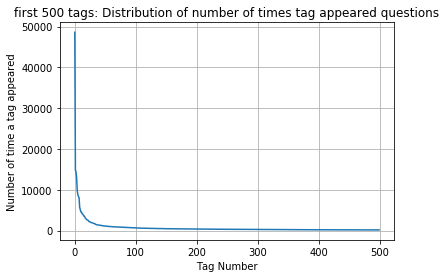

In [18]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel('Tag Number')
plt.ylabel('Number of time a tag appeared')
plt.show()

In [19]:
print(tag_counts[0:500:5])

[48628  8746  4568  3541  2650  2121  1852  1470  1297  1213  1116  1023
   983   913   869   835   810   757   697   671   652   614   595   579
   554   540   525   504   492   469   460   455   442   435   431   419
   410   404   393   382   375   370   362   357   351   345   332   329
   326   320   315   304   300   294   290   283   281   278   275   273
   267   263   261   259   250   248   242   237   235   232   226   223
   218   216   213   211   209   207   203   201   199   196   193   190
   189   188   186   184   182   180   180   178   174   173   172   170
   168   167   164   163]


In [20]:
tag_use_gt_10k = tag_df[tag_df.Count > 10000].Tags
tag_use_gt_1k = tag_df[tag_df.Count > 1000].Tags
tag_use_gt_5k = tag_df[tag_df.Count > 5000].Tags

print ('{} Tags are used more than 10000 times'.format(len(tag_use_gt_10k)))
print ('{} Tags are used more than 1000 times'.format(len(tag_use_gt_1k)))
print ('{} Tags are used more than 5000 times'.format(len(tag_use_gt_5k)))

4 Tags are used more than 10000 times
58 Tags are used more than 1000 times
10 Tags are used more than 5000 times


#### Obesrvations :

* 4 Tags are used more than 10000 times, 58 Tags are used more than 1000 times and only 10 Tags are used more than 5000 times.
* Top 2 mostly used and frequents tags are android : 48628 times & c# : 14759 times.

In [21]:
tag_quest_count = tag_dtm.sum(axis=1).flatten().tolist()[0]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))
print('different no. of tags assigned to a question: ', set(tag_quest_count))

We have total 200000 datapoints.
different no. of tags assigned to a question:  {1, 2, 3, 4, 5}


In [22]:
print('Maximum tags assigned to a question:', max(tag_quest_count))
print('Minimum tags assigned to a question:', min(tag_quest_count))
print('Minimum tags assigned to a question:', (sum(tag_quest_count)/len(tag_quest_count)))

Maximum tags assigned to a question: 5
Minimum tags assigned to a question: 1
Minimum tags assigned to a question: 2.92344


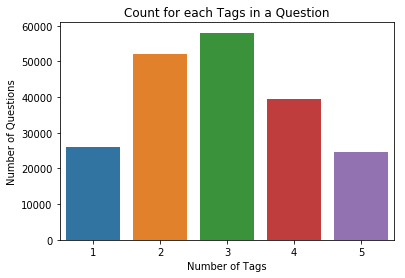

In [23]:
# countplot for each tag :
sns.countplot(tag_quest_count)
plt.title('Count for each Tags in a Question')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Questions')
plt.show()

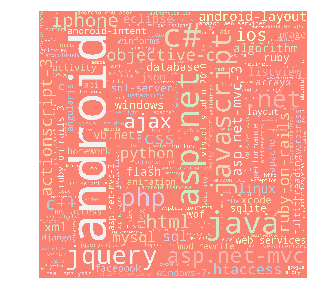

In [24]:
tup = dict(results.items())
wordcloud = WordCloud(width = 6000, height = 6000, background_color='salmon', colormap='Pastel1').generate_from_frequencies(tup)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

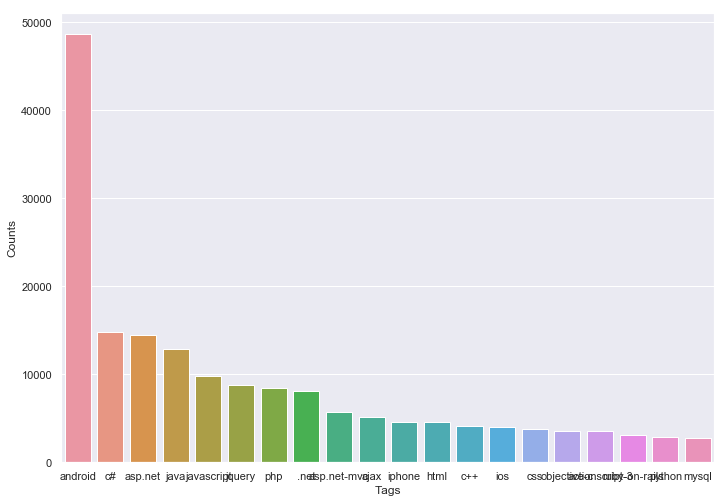

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = tag_df_sorted[0:20] , x = 'Tags', y = 'Count', )
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [42]:
df_no_dup.tag_count.value_counts()

3    58061
2    51980
4    39382
1    25967
5    24610
Name: tag_count, dtype: int64

Text(0.5,1,'Distribution of Tag count')

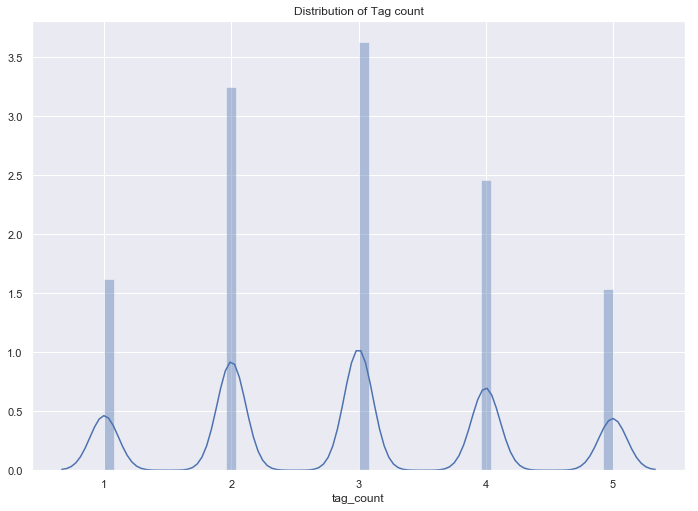

In [43]:
sns.distplot(df_no_dup['tag_count']).set_title('Distribution of Tag count')

In [63]:
counts, bin_edges = np.histogram(df_no_dup['tag_count'], bins = 5, density= True)
pdf_tag_counts = counts/sum(counts)
cdf_tag_counts = np.cumsum(pdf_tag_counts)

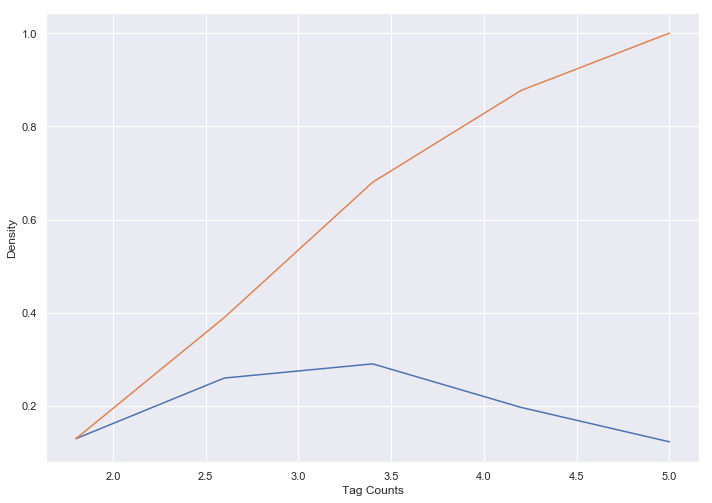

In [64]:
plt.plot(bin_edges[1:],pdf_tag_counts)
plt.plot(bin_edges[1:],cdf_tag_counts)
plt.xlabel('Tag Counts')
plt.ylabel('Density')
plt.show()

#### Observations :

* most popular OS is android.
* most top 3 frequently used programming languages are C#, asp.net and java.
* most of the questions have 3 or 2 tags on stackoverflow.
* 65 % of questions are having 1 to 3 tags
* 80 % of questions are having 1 to 4 tags
* Max. no. of tags for a question is 5.
* Min. no. of tags for a question is 1.

In [66]:
df = df_no_dup[0:40000].copy()

In [78]:
print(df.shape)
df.head(3)

(40000, 5)


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4


In [152]:
df_pro = pd.DataFrame(columns= ['question','code','tags','words_pre','words_post','is_code'])

* check for code in body
* words_pre = len(question)+len(title) before preprocessing
* filter code from body and load code in new variable
* clean the boady(question), title + question
* tags = tags in no_dup_df
* word_post = len(question)+len(title) after preprocessing


* question = body + title
* code = code in body
* tag = tag in no_dup_df
* words_pre = len(question)+len(title) before preprocessing
* word_post = len(question)+len(title) after preprocessing
* is_code = if code exists in the body

In [153]:
def striphtml(data):
    cleanr = re.compile('<.*?>')  ## By using the regex: <.*?>,we're filtering out all of the words and characters that 
# are inside angle brackets including angle brackest. As mostly all of the html is written under these brackets as known as html tags.
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [154]:
len_pre=0
len_post=0
questions_with_code = 0
for i in range(len(df)):
    is_code = 0
    title = df['Title'][i]
    question = df['Body'][i]
    tags = df['Tags'][i]
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
        words_pre = len(question) + len(title)
        len_pre+=words_pre
    
    # filter code from body of the question
    code = str(re.findall('<code>(.*?)</code>', question,flags= re.DOTALL))
    
    # Remove code from the question
    question = re.sub('<code>(.*?)</code>','',question, flags = re.DOTALL|re.MULTILINE)
    question = striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    question = str(title) + str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    words_post = len(question)
    df_pro = df_pro.append({'question' : question, 'code': code, 'tags' : tags, 'words_pre': words_pre,'words_post' : words_post, 'is_code' : is_code}, ignore_index= True)
    

In [164]:
for i in range(0,10):
    print(df_pro['question'][i])
    print('='*100)

implement boundari valu analysi softwar test c program answer come form tabl like input rang could vari output come anyon correct code tell wrong
dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advanc
dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advanc
java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl tomcat webapp tri project work also tri version jstl still messag caus solv
java sql sqlexcept microsoft odbc driver manag invalid descriptor index use follow code display caus solv
better way updat feed fb php sdk novic facebook api read mani tu

In [175]:
df_pro.head()

,question,code,tags,words_pre,words_post,is_code
0,implement boundari valu analysi softwar test c...,['#include&lt;iostream&gt;\n#include&lt;stdlib...,c++ c,2116,145,1
1,dynam datagrid bind silverlight bind datagrid ...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding,904,185,1
2,dynam datagrid bind silverlight bind datagrid ...,['MyClass myInstance = new MyClass();\ndataGri...,c# silverlight data-binding columns,904,185,1
3,java lang noclassdeffounderror javax servlet j...,"['&lt;%@taglib prefix=""c"" uri=""http://java.sun...",jsp jstl,745,311,1
4,java sql sqlexcept microsoft odbc driver manag...,"['try {\n Class.forName(""sun.jdbc.odbc.Jdbc...",java jdbc,1056,105,1


In [176]:
vectorizer = CountVectorizer(tokenizer= lambda x : x.split(), binary = True)
multilabel_y = vectorizer.fit_transform(df_pro['tags'])

In [200]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn
def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [255]:
multilabel_yx = tags_to_choose(1000)
print("number of questions that are not covered :", questions_explained_fn(5500))

number of questions that are not covered : 191


In [256]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 11336
number of tags taken : 1000 ( 8.821453775582217 %)


### Train_Test_Split - 80:20

In [220]:
df_pro_main = df_pro[['question','tags']].copy()

In [222]:
df_pro_main.head()

,question,tags
0,implement boundari valu analysi softwar test c...,c++ c
1,dynam datagrid bind silverlight bind datagrid ...,c# silverlight data-binding
2,dynam datagrid bind silverlight bind datagrid ...,c# silverlight data-binding columns
3,java lang noclassdeffounderror javax servlet j...,jsp jstl
4,java sql sqlexcept microsoft odbc driver manag...,java jdbc


In [257]:
total_size=df_pro_main.shape[0]
train_size=int(0.80*total_size)

x_train=df_pro_main.head(train_size)
x_test=df_pro_main.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [258]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (32000, 1000)
Number of data points in test data : (8000, 1000)


##### Now we have 2 features : questions and tags. Tags is already featurized and lets featurize the question feature.

In [270]:
vectorizer = TfidfVectorizer(min_df=0.00009,smooth_idf=True,norm= "l2",sublinear_tf= False, \
                            tokenizer = lambda x : x.split(),ngram_range = (1,3))

x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])

In [269]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=9e-05,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x000002BDD31EC0D0>, use_idf=True,
        vocabulary=None)

In [271]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (32000, 143416) Y : (32000, 1000)
Dimensions of test data X: (8000, 143416) Y: (8000, 1000)


### Modeling :


* SGD classifier, and Logistic regression seems similar. An SGD classifier with loss = 'log' implements Logistic regression and loss = 'hinge' implements Linear SVM.

* clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42) it is an implementation of Linear SVM and if I write clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42) . It is an implementation of Logisitic regression

#### OnevsRest with log loss SGDClassifier

In [272]:
classifier  = OneVsRestClassifier(estimator= SGDClassifier(loss = 'log',  alpha=0.00001, penalty='l1'),n_jobs= -1)
classifier.fit(x_train_multilabel,y_train)
predctions = classifier.predict(x_test_multilabel)

In [274]:
print("Accuracy :",accuracy_score(y_test, predctions))
print("Hamming loss ",hamming_loss(y_test,predctions))


precision = precision_score(y_test, predctions, average='micro')
recall = recall_score(y_test, predctions, average='micro')
f1 = f1_score(y_test, predctions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predctions, average='macro')
recall = recall_score(y_test, predctions, average='macro')
f1 = f1_score(y_test, predctions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Accuracy : 0.103875
Hamming loss  0.002024875
Micro-average quality numbers
Precision: 0.6018, Recall: 0.2256, F1-measure: 0.3282
Macro-average quality numbers
Precision: 0.3011, Recall: 0.1409, F1-measure: 0.1769


#### OnevsRest with  hinge loss SGDClassifier

In [276]:
classifier_svm  = OneVsRestClassifier(estimator= SGDClassifier(loss = 'hinge',  alpha=0.00001, penalty='l1'),n_jobs= -1)
classifier_svm.fit(x_train_multilabel,y_train)
predictions_svm = classifier_svm.predict(x_test_multilabel)

In [277]:
print("Accuracy :",accuracy_score(y_test, predictions_svm))
print("Hamming loss ",hamming_loss(y_test,predictions_svm))


precision = precision_score(y_test, predictions_svm, average='micro')
recall = recall_score(y_test, predictions_svm, average='micro')
f1 = f1_score(y_test, predictions_svm, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_svm, average='macro')
recall = recall_score(y_test, predictions_svm, average='macro')
f1 = f1_score(y_test, predictions_svm, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Accuracy : 0.118125
Hamming loss  0.0019475
Micro-average quality numbers
Precision: 0.6553, Recall: 0.2355, F1-measure: 0.3465
Macro-average quality numbers
Precision: 0.2515, Recall: 0.1489, F1-measure: 0.1715


#### OnevsRest with LogisticRegression

In [278]:
classifier_log  = OneVsRestClassifier(estimator= LogisticRegression(),n_jobs= -1)
classifier_log.fit(x_train_multilabel,y_train)
predictions_log = classifier_log.predict(x_test_multilabel)

In [279]:
print("Accuracy :",accuracy_score(y_test, predictions_log))
print("Hamming loss ",hamming_loss(y_test,predictions_log))


precision = precision_score(y_test, predictions_log, average='micro')
recall = recall_score(y_test, predictions_log, average='micro')
f1 = f1_score(y_test, predictions_log, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_log, average='macro')
recall = recall_score(y_test, predictions_log, average='macro')
f1 = f1_score(y_test, predictions_log, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.075875
Hamming loss  0.002099
Micro-average quality numbers
Precision: 0.7045, Recall: 0.0733, F1-measure: 0.1327
Macro-average quality numbers
Precision: 0.0528, Recall: 0.0097, F1-measure: 0.0151


#### Observations :

* SGDClassfier with loss 'hinge' gave us better results compared to SGDClassfier with loss 'log'.
* Logistic Regression also gave us bad results.